## **DESCRIPCION DEL TRABAJO Y CONCEPTOS BASICOS DE AUDIO**

####**Clasificación de géneros musicales con el conjunto de datos GTZAN**
####Archivos de audio | Espectrogramas Mel | CSV con características extraídas

En este proyecto, clasificaremos las señales de audio musicales en generos musicales utilizando:
- Aprendizaje automatico (Machine Learning, ML)
- Aprendizaje profundo (Deep Learning, DL)

Para los modelos de ML y DL, se requieren que los sonidos musicales se representen mediante espectogramas de MEL.

Para obtener más información sobre el conjunto de datos, utilice el siguiente enlace de Kaggle:
https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification

## **INICIO**
---

In [6]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import tensorflow 
from tensorflow.python.client import device_lib
def print_info():
     print('  Versión de TensorFlow: {}'.format(tensorflow.__version__))
     print('  GPU: {}'.format([x.physical_device_desc for x in device_lib.list_local_devices() if x.device_type == 'GPU']))
     print('  Versión Cuda  -> {}'.format(tensorflow.sysconfig.get_build_info()['cuda_version']))
     print('  Versión Cudnn -> {}\n'.format(tensorflow.sysconfig.get_build_info()['cudnn_version']))

print_info()

  Versión de TensorFlow: 2.9.2
  GPU: []
  Versión Cuda  -> 11.2
  Versión Cudnn -> 8



**Montando Google Drive**

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Estableciendo una variable de ambiente para la ruta donde descargar el dataset GTZAN**

In [10]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/dataset_GTZAN_kaggle"

**Cambiando el directorio de trabajo donde se descargara el dataset GTZAN**

In [11]:
cd  /content/drive/MyDrive/dataset_GTZAN_kaggle

/content/drive/MyDrive/dataset_GTZAN_kaggle


**Descargando el dataset GTZAN en formato zip desde kaggle**

In [12]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

gtzan-dataset-music-genre-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


**Desempaquetando el dataset en formato zip**

In [13]:
!unzip gtzan-dataset-music-genre-classification.zip

Archive:  gtzan-dataset-music-genre-classification.zip
replace Data/features_30_sec.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Data/features_3_sec.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


## **SECCION I - PREPROCESAMIENTO DE DATOS DE AUDIO**
---

**Importando librerías**

In [14]:
# importando librerias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from glob import glob # nos permite listar todos los archivos en un directorio
import IPython
import IPython.display as ipd # para reproducir los archivos de audio

import librosa # paquete principal para trabajar con datos de audio
import librosa.display

**Leer los archivos de audio**
Con el uso del paquete glob, podemos enumerar todos los archivos en las carpetas.

In [15]:
# Haga una lista de todos los archivos wav en el conjunto de datos y guárdelos en una variable
audio_files = glob("/content/drive/MyDrive/dataset_GTZAN_kaggle/Data/genres_original/*/*.wav")

Con el uso de '*' (asteriscos) podemos enumerar todos los elementos en el conjunto de datos. Reemplaza los asteriscos con cualquier archivo que exista en el conjunto de datos.

**Escuchar los archivos de audio**
Con el uso del módulo de visualización de IPhytons podemos mostrar los archivos de audio. Obtenemos un reproductor en el cuaderno donde podemos escuchar el archivo de audio. Tomar en cuenta que en realidad no leímos el archivo y no podemos manipularlo todavía.

In [16]:
# Reproducir el primer archivo de audio
ipd.Audio(audio_files[0])

**Carga de los archivos de audio**   
Aquí usamos librosa y su función load() para leer los archivos de audio. Guardamos las salidas como 'y' y sr':

- y: datos sin procesar del archivo de audio (matriz numpy)
- sr: valor entero de la frecuencia de muestreo

In [17]:
# cargue el archivo de audio y muestre los datos sin procesar y la frecuencia de muestreo
y, sr = librosa.load(audio_files[0])
print("Y is a numpy array:", y)
print("Shape of Y:", y.shape)
print("Sample Rate:", sr)

Y is a numpy array: [-0.01300049 -0.03060913 -0.03607178 ...  0.0098877   0.01107788
  0.0118103 ]
Shape of Y: (661794,)
Sample Rate: 22050


Podemos ver que los datos sin procesar de nuestros archivos de audio (y) son matrices numpy y, en este caso, nuestra frecuencia de muestreo (sr) es 22050.

**Grafica de los archivos de audio**   
Una forma de graficar la matriz de datos de audio sin procesar es convertirla en una serie de pandas y usar la función plot().

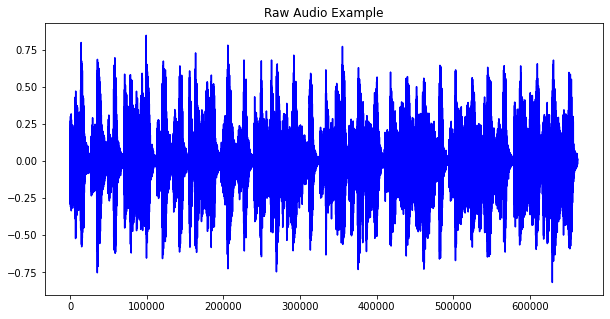

In [18]:
# convierta la matriz de datos sin procesar en serie pd y trace el ejemplo de audio
pd.Series(y).plot(figsize=(10,5), title="Raw Audio Example", color='blue');

También podemos usar la función display.waveshow() de librosa.

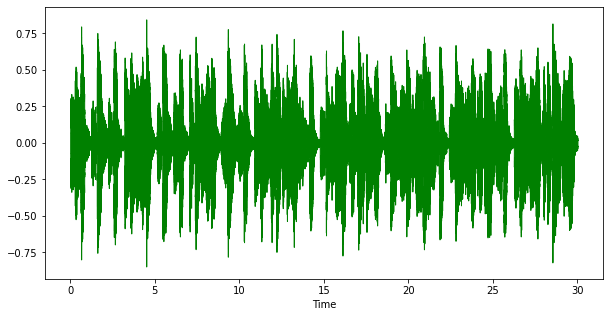

In [19]:
plt.figure(figsize=(10,5))
librosa.display.waveshow(y, color = "Green")
plt.show()

**Aplicando STFT (Short Time Fourier Transform)**

Queremos llevarlo al siguiente nivel observando las diferentes frecuencias según su potencia.
Hacemos esto aplicando una **transformada de Fourier** a los datos de audio. Eso nos permite extraer qué frecuencias suenan en diferentes partes del archivo de audio. Usamos la función stft() (**Short-time Fourier Transform**, Transformada de Fourier de tiempo corto).
Luego aplicamos la función de amplitud a db a la salida de STFT, que es una transformación comúnmente utilizada para datos de audio para convertir valores de amplitud a decibelios (dB).
Con esto obtenemos datos que podemos alimentar a los modelos ML normales.

In [20]:
# Use STFT en datos de audio sin procesar
D = librosa.stft(y)
# convertir valores de amplitud a decibelios tomando el valor absoluto de D en referencia a cuál sería el valor máximo
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
# ver la forma de los datos transformados
print("Nueva forma de datos transformados", S_db.shape)

Nueva forma de datos transformados (1025, 1293)


**Grafica de un archivo de audio como un espectrograma**  
Un espectrograma es una representación visual del espectro de frecuencias en un sonido u otra señal a medida que varía con el tiempo. El gráfico resultante es un gráfico bidimensional, con la frecuencia en el eje vertical y el tiempo en el eje horizontal. Los espectrogramas se utilizan a menudo en el análisis y la manipulación de señales de audio, especialmente en los campos de la música, el habla y la acústica.

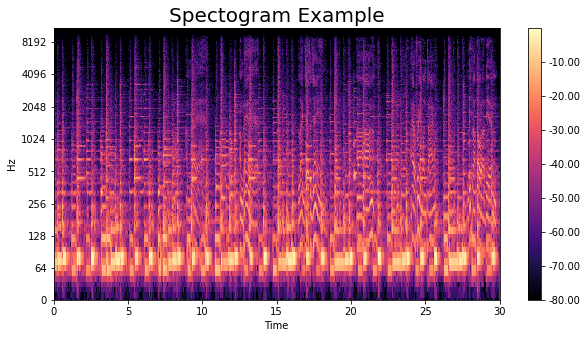

In [21]:
# trazar datos transformados como espectrograma
fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=ax)
ax.set_title('Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f');

**Crear un Espectrograma Mel (Espectrograma Melódico)**  
Un espectrograma Mel es un tipo de espectrograma que representa el contenido espectral de un sonido o señal en una escala que se basa en el tono percibido de las diferentes frecuencias. La escala de Mel es una escala logarítmica que asigna la frecuencia al tono de una manera que está más estrechamente relacionada con la forma en que el sistema auditivo humano percibe el tono.

In [22]:
# aplicar espectrograma mel sin STFT
S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128*2)
print("Shape of Mel Spectogram", S.shape)
# use esa función de conversión como arriba
S_db_mel = librosa.amplitude_to_db(S, ref=np.max)

Shape of Mel Spectogram (256, 1293)


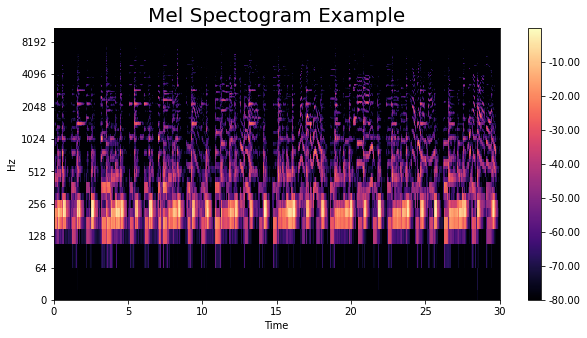

In [23]:
# trazar el espectrograma de mel
fig, ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(S_db_mel, x_axis='time', y_axis='log', ax=ax)
ax.set_title('Mel Spectogram Example', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f');

**EDA - Exploratory Data Analysis (Análisis de datos exploratorios)**


In [24]:
# cargar el archivo csv 
df = pd.read_csv("/content/drive/MyDrive/dataset_GTZAN_kaggle/Data/features_3_sec.csv")

In [25]:
df.head() # primeras 5 entradas

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [26]:
df.shape # ver la forma de df

(9990, 60)

In [27]:
df.info() # información sobre las muestras, características y tipos de datos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 9990 non-null   object 
 1   length                   9990 non-null   int64  
 2   chroma_stft_mean         9990 non-null   float64
 3   chroma_stft_var          9990 non-null   float64
 4   rms_mean                 9990 non-null   float64
 5   rms_var                  9990 non-null   float64
 6   spectral_centroid_mean   9990 non-null   float64
 7   spectral_centroid_var    9990 non-null   float64
 8   spectral_bandwidth_mean  9990 non-null   float64
 9   spectral_bandwidth_var   9990 non-null   float64
 10  rolloff_mean             9990 non-null   float64
 11  rolloff_var              9990 non-null   float64
 12  zero_crossing_rate_mean  9990 non-null   float64
 13  zero_crossing_rate_var   9990 non-null   float64
 14  harmony_mean            

**Se verifica si hay valores perdidos**

In [28]:
df.isnull().sum() # comprobación de valores perdidos

filename                   0
length                     0
chroma_stft_mean           0
chroma_stft_var            0
rms_mean                   0
rms_var                    0
spectral_centroid_mean     0
spectral_centroid_var      0
spectral_bandwidth_mean    0
spectral_bandwidth_var     0
rolloff_mean               0
rolloff_var                0
zero_crossing_rate_mean    0
zero_crossing_rate_var     0
harmony_mean               0
harmony_var                0
perceptr_mean              0
perceptr_var               0
tempo                      0
mfcc1_mean                 0
mfcc1_var                  0
mfcc2_mean                 0
mfcc2_var                  0
mfcc3_mean                 0
mfcc3_var                  0
mfcc4_mean                 0
mfcc4_var                  0
mfcc5_mean                 0
mfcc5_var                  0
mfcc6_mean                 0
mfcc6_var                  0
mfcc7_mean                 0
mfcc7_var                  0
mfcc8_mean                 0
mfcc8_var     

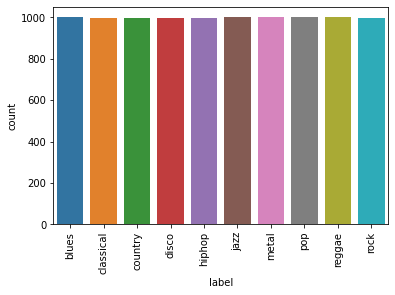

In [29]:
sns.countplot(x=df.label) # grafica de las categoriaes
plt.xticks(rotation=90);

Tenemos una cantidad uniforme de todas las categorías con 9990 muestras.

**Estandarizacion y etiquetado de los datos**  
Después de colocar la columna de nombre de archivo y asignar nuestra x e y, usamos StandardScaler en nuestros valores de x para estandarizar nuestros datos y LabelEncoder para nuestras etiquetas. Luego dividimos nuestros datos en datos de entrenamiento y prueba.

In [30]:
# elimina la columna de nombre de archivo y muestre las primeras nuevas 5 entradas de df
df = df.drop(labels='filename',axis=1)
df.head()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [31]:
# importar codificador de etiquetas y escalador
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
encoder = LabelEncoder()
scaler = StandardScaler()

In [32]:
data = df.iloc[:, :-1] # obtener las otras columnas
data

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,...,-2.853603,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767
1,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,...,4.074709,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081
2,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,...,4.806280,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122
3,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,...,-1.359111,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678
4,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,...,2.092937,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,66149,0.349126,0.080515,0.050019,0.000097,1499.083005,164266.886443,1718.707215,85931.574523,3015.559458,...,5.773784,42.485981,-9.094270,38.326839,-4.246976,31.049839,-5.625813,48.804092,1.818823,38.966969
9986,66149,0.372564,0.082626,0.057897,0.000088,1847.965128,281054.935973,1906.468492,99727.037054,3746.694524,...,2.074155,32.415203,-12.375726,66.418587,-3.081278,54.414265,-11.960546,63.452255,0.428857,18.697033
9987,66149,0.347481,0.089019,0.052403,0.000701,1346.157659,662956.246325,1561.859087,138762.841945,2442.362154,...,-1.005473,78.228149,-2.524483,21.778994,4.809936,25.980829,1.775686,48.582378,-0.299545,41.586990
9988,66149,0.387527,0.084815,0.066430,0.000320,2084.515327,203891.039161,2018.366254,22860.992562,4313.266226,...,4.123402,28.323744,-5.363541,17.209942,6.462601,21.442928,2.354765,24.843613,0.675824,12.787750


In [33]:
labels = df.iloc[:, -1] # obtener columna de etiquetas
labels.to_frame()

,label
0,blues
1,blues
2,blues
3,blues
4,blues
...,...
9985,rock
9986,rock
9987,rock
9988,rock


**Preparando x e y**

In [34]:
# asignar x e y, escalar x y codificar y
x = np.array(data, dtype = float)
x = scaler.fit_transform(data)
y = encoder.fit_transform(labels)
x.shape, y.shape

((9990, 58), (9990,))

In [35]:
# dividir datos para entrenar y datos para probar
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)
x_train.shape, x_test.shape, y_train.shape, y_test.shape
#((6693, 58), (3297, 58), (6693,), (3297,))

((6693, 58), (3297, 58), (6693,), (3297,))

# **SECCION II - CONSTRUYENDO LOS MODELOS DE APRENDIZAJE AUTOMATICO**
---

### **Modelos GaussianNB, BernoulliNB, KNeighborClassifier, DecisionTreeClassifier y XGBClassifier con sklearn**

In [36]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
    
# crear una instancia de cada algoritmo de clasificación
g=GaussianNB()
b=BernoulliNB()
KN=KNeighborsClassifier()
D=DecisionTreeClassifier()
XGB=XGBClassifier()

algos=[g,b,KN,D,XGB]
algo_names=['GaussianNB','BernoulliNB','KNeighborsClassifier','DecisionTreeClassifier','XGBClassifier']  


# **SECCION III - EVALUACION DE LOS MODELOS DE APRENDIZAJE AUTOMATICO**
---

### **Evaluacion de los modelos**

In [37]:
accuracy_scored=[]
    
# ajustar y predecir para cada Algoritmo
for item in algos:
    item.fit(x_train,y_train)
    item.predict(x_test)
    accuracy_scored.append(accuracy_score(y_test,item.predict(x_test)))

### **Mostrar los resultados en una tabla Dataframe**

In [38]:
# mostrar resultados en un DataFrame
result = pd.DataFrame(accuracy_scored, columns=["Accuracy"])
result['Algos']=algo_names
result.sort_values('Accuracy',ascending=False)

,Accuracy,Algos
2,0.864119,KNeighborsClassifier
4,0.785563,XGBClassifier
3,0.628753,DecisionTreeClassifier
0,0.531392,GaussianNB
1,0.481650,BernoulliNB


El mejor resultado lo muestra el **XGBClassifier** con una **Precisión del 87,41%**.   
Veamos si podemos lograr mejores resultados usando Deep Learning.

#**SECCION IV - CONSTRUCCION Y EVALUACION DE UNA RED NEURONAL PARA APRENDIZAJE PROFUNDO**
---

**Contruyendo el modelo con tensorflow y keras**

In [39]:
# importar bibliotecas de aprendizaje profundo
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential

**Arquitectura sin redes convolucionales**

In [40]:
# Construcción del modelo
model = keras.models.Sequential([
    keras.layers.Dense(512, activation="relu", input_shape=(x_train.shape[1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256,activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128,activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64,activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation="softmax"),  
])

**Resumen del modelo**

In [41]:
print(model.summary()) # muestra el resumen del modelo

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               30208     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8

**Compilando el modelo**

In [42]:
# Compilando el modelo  
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')

**Entrenando el modelo**

In [43]:
# Ajuste del modelo - entrenamiento
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=300, batch_size=128)

Epoch 1/300
53/53 [==============================] - 2s 16ms/step - loss: 1.6758 - accuracy: 0.4009 - val_loss: 1.1496 - val_accuracy: 0.6054
Epoch 2/300
53/53 [==============================] - 1s 12ms/step - loss: 1.1527 - accuracy: 0.5975 - val_loss: 0.9093 - val_accuracy: 0.7015
Epoch 3/300
53/53 [==============================] - 1s 12ms/step - loss: 0.9500 - accuracy: 0.6801 - val_loss: 0.7915 - val_accuracy: 0.7395
Epoch 4/300
53/53 [==============================] - 1s 13ms/step - loss: 0.8184 - accuracy: 0.7231 - val_loss: 0.7206 - val_accuracy: 0.7668
Epoch 5/300
53/53 [==============================] - 1s 13ms/step - loss: 0.7142 - accuracy: 0.7599 - val_loss: 0.6155 - val_accuracy: 0.7925
Epoch 6/300
53/53 [==============================] - 1s 11ms/step - loss: 0.6259 - accuracy: 0.7920 - val_loss: 0.6022 - val_accuracy: 0.8050
Epoch 7/300
53/53 [==============================] - 1s 13ms/step - loss: 0.5779 - accuracy: 0.8098 - val_loss: 0.5514 - val_accuracy: 0.8223
Epoch 

**Evaluando la precision del modelo**

In [44]:
# evaluar el modelo
_, accuracy = model.evaluate(x_test, y_test, batch_size=128)
#26/26 [==============================] - 0s 3ms/step - loss: 0.4606 - accuracy: 0.9284
print("Accuracy:",accuracy) # print accuracy
#Accuracy: 0.9284197688102722

26/26 [==============================] - 0s 3ms/step - loss: 0.5082 - accuracy: 0.9199
Accuracy: 0.919927179813385


Con Deep Learning logramos una **Precisión del 92,44%**.

**Grafica de la exactitud por epocas**

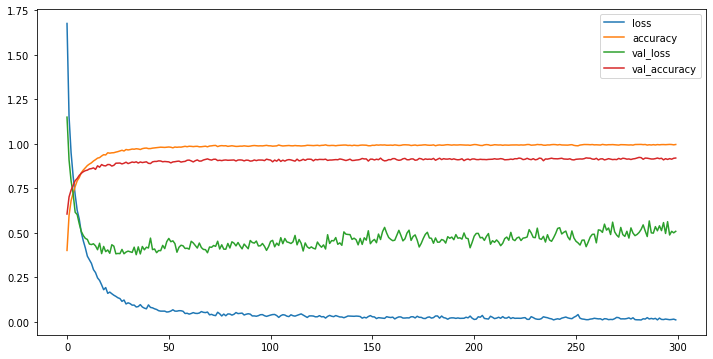

In [45]:
# Plot results
pd.DataFrame(history.history).plot(figsize=(12,6))
plt.show()

In [46]:
pd.DataFrame(history.history).shape

(300, 4)

In [47]:
pd.DataFrame(history.history).min()

loss            0.010265
accuracy        0.400867
val_loss        0.376862
val_accuracy    0.605399
dtype: float64

In [48]:
pd.DataFrame(history.history).max()

loss            1.675796
accuracy        0.996414
val_loss        1.149619
val_accuracy    0.923567
dtype: float64

#**Construccion de red neuronal preentrenada**

**Cargar Modelo pre-entrenado DenseNet:**

In [49]:
# https://www.tensorflow.org/api_docs/python/tf/keras/applications
img_width = 224
img_height = 224
batch_size = 40

pretrained_model_name = 'VGG16'
project_folder = "/content/drive/MyDrive/DrFIIS/2022-2/covid19-pretrained-models"

from tensorflow.keras.applications.vgg16 import VGG16

# Cargando modelo
pretrained_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

pretrained_model.summary();

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

**Se indica que la parte de caracterización no es entrenable**

In [50]:
for layer in pretrained_model.layers:
    layer.trainable = False

pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

**Agregando el clasificador nuevo**

In [51]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GlobalAveragePooling2D
from keras.layers import Flatten
from keras.layers import Dropout

# Definiendo una Red Neuronal vacía
model = Sequential()

# Agregando la parte convolucional (base)
model.add(pretrained_model)               # Modelo base

# Clasificador propio
model.add(GlobalAveragePooling2D())       # GlobalAveragePooling2D https://adventuresinmachinelearning.com/global-average-pooling-convolutional-neural-networks/
model.add(Dense(1000, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(1, activation='sigmoid'))

print("Arquitectura final:")
model.summary()

Arquitectura final:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_5 (Dense)             (None, 1000)              513000    
                                                                 
 dropout_4 (Dropout)         (None, 1000)              0         
                                                                 
 dense_6 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 15,228,689
Trainable params: 514,001
Non-trainable params: 14,714,688
________________

**Grafica de la arquitectura del modelo**

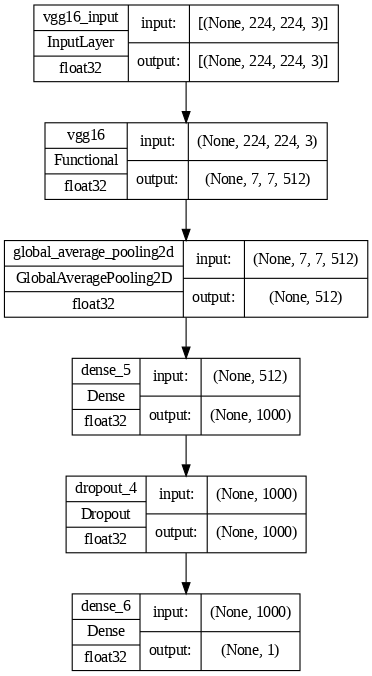

In [52]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_dtype=True, show_shapes=True, show_layer_names=True, rankdir='TB',to_file=project_folder + '/output/' + pretrained_model_name + '_plot.png',dpi=80)

**Compilando la red neuronal**

In [53]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam

opt = SGD(learning_rate=0.008, momentum=0.9)
# opt = Adam(lr=0.008, beta_1=0.9, beta_2=0.999)

# COMPILANDO la Red Neuronal Convolucional
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

**Entrenando la red nuronal**

In [55]:
num_imgs_testin=len(x_test)

In [ ]:
%%time
batch_size=40
epochs=20
training_set_imgs=x_train
testing_set_imgs=x_test
num_imgs_training=len(x_train)
num_imgs_testing=len(x_test)


# Entrenar
history = model.fit(training_set_imgs,
                    epochs=epochs,
                    steps_per_epoch=np.ceil(num_imgs_training/batch_size),
                    validation_data=testing_set_imgs,
                    validation_steps=np.ceil(num_imgs_testing/batch_size))